# Проект: классификация

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit (вложил ли клиент деньги в банк)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Прочитаем данные и посмотрим, есть ли пропуски

In [18]:
df = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/dab91dc74eb3cb684755123d224d262b/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [20]:
df.balance.isnull().sum()

25

Пропуски есть в признаке balamce - их 25

### Проверим, нет ли закодированных пропусков в признаках job и education

In [21]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [22]:
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

Мы видим значение unknown - это закодированный пропуск

### Чтобы признак balance считывался как число, уберём и него пробел и знак доллара

In [23]:
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',00', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype('float')

### Заменим пропуски в balance на медианное значение

In [24]:
df['balance'] = df['balance'].fillna(df['balance'].median())

### Заменим unknown в признаках работы и образования на моду

In [25]:
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

### Удалим выбросы из признака balance по методу Тьюки

In [26]:
q3 = np.percentile(df['balance'], 75)
q1 = np.percentile(df['balance'], 25)

lower_bound = q1 - 1.5*(q3-q1)
upper_bound = q3 + 1.5*(q3-q1)

print(lower_bound, upper_bound)

-2241.0 4063.0


In [27]:
df = df[(df.balance >= lower_bound) & (df.balance <= upper_bound)]
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Посмотрим на распределение целевой переменной - есть ли несбалансированность классов?

In [28]:
df.deposit.value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

<AxesSubplot:xlabel='deposit', ylabel='count'>

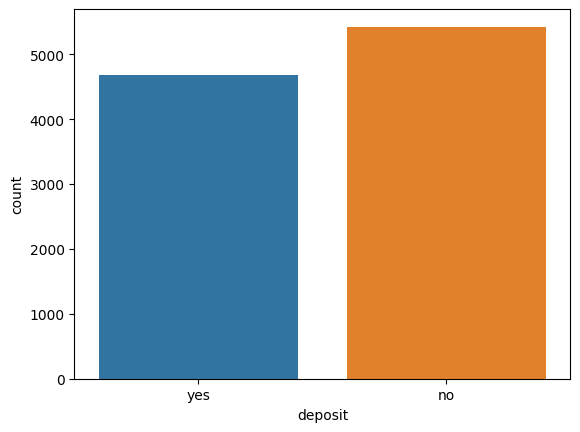

In [29]:
sns.countplot(x=df.deposit)

Да, заметна несбалансированность

### Посмотрим на описательную статистику количественных переменных

In [30]:
print(df.age.max())
print(df.age.min())

95
18


In [31]:
print(df.duration.max())
print(df.duration.min())

3881
2


### Посмотрим на описательную статистику категориальных переменных

In [32]:
df.month.nunique()

12

Маркетинговая компания проводилась во все месяцы

In [33]:
df.job.nunique()

11

Среди клиентов представлено 11 сфер занятости

### Узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. Посмотрим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

<AxesSubplot:xlabel='poutcome'>

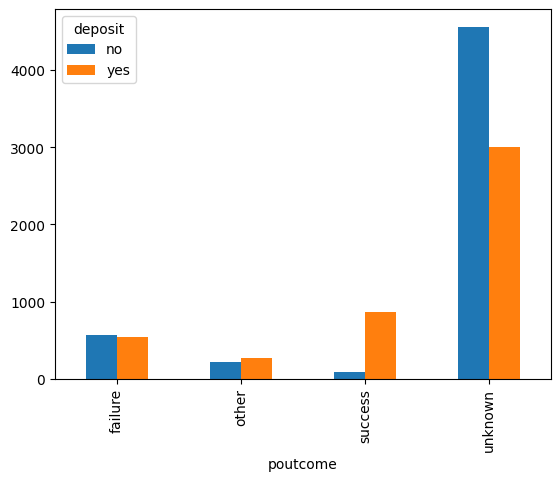

In [34]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar')

Видим, что если статус предыдущей маркетинговой кампании - success, то в текущей кампании у неё тоже намного больше успехов, чем неудач

### Посмотрим, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании

In [35]:
months = df.groupby("month")['deposit'].value_counts(normalize=False).unstack()
months

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


In [36]:
result = months.apply(lambda row: row['no'] / (row['yes'] + row['no']), axis=1).sort_values(ascending=False)
print(result)

month
may    0.678640
jan    0.608150
jul    0.589563
nov    0.584615
aug    0.559567
jun    0.548913
feb    0.455571
apr    0.381928
oct    0.185075
sep    0.165468
mar    0.101266
dec    0.096774
dtype: float64


### Создадим новую переменную, обозначающую возрастные группы, и посмотрим, какие группы более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения

<AxesSubplot:xlabel='age_group', ylabel='count'>

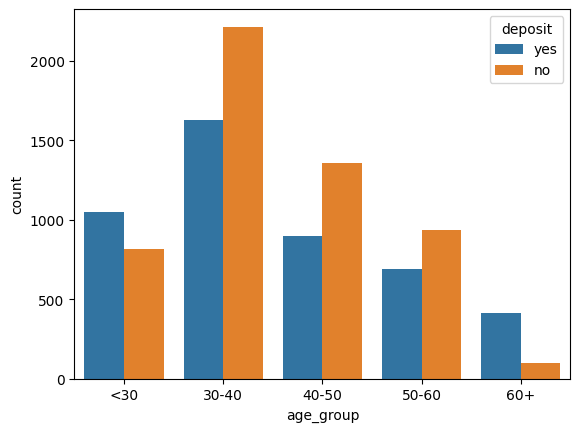

In [37]:
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

### Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от семейного положения, уровня образования, сферы занятости

<AxesSubplot:xlabel='count', ylabel='marital'>

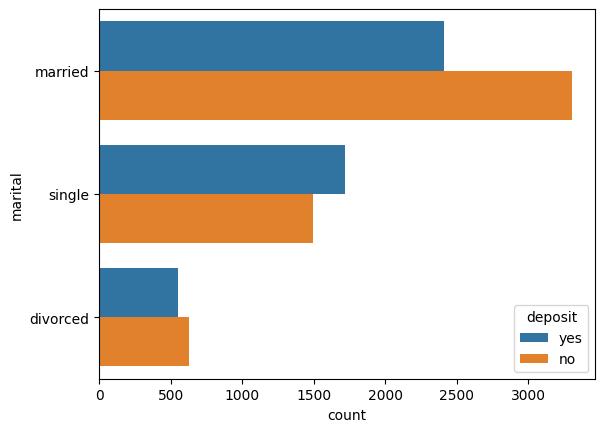

In [38]:
sns.countplot(y='marital', hue='deposit', data=df)

<AxesSubplot:xlabel='count', ylabel='education'>

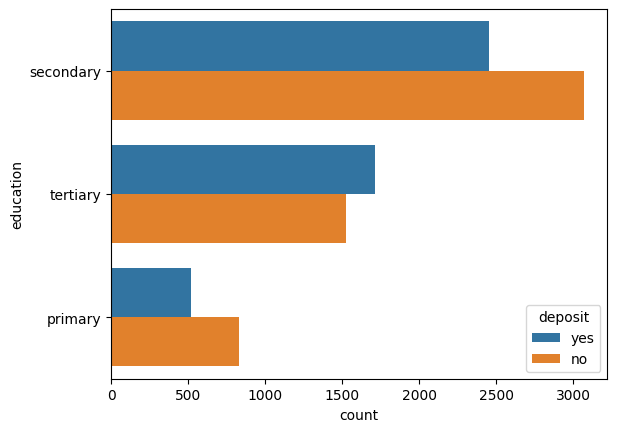

In [39]:
sns.countplot(y='education', hue='deposit', data=df)

<AxesSubplot:xlabel='count', ylabel='job'>

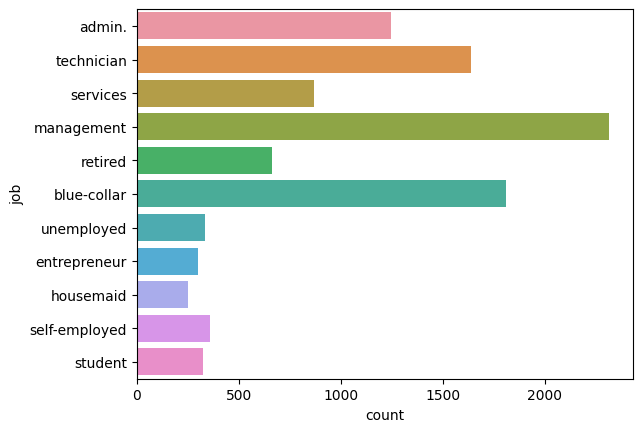

In [40]:
sns.countplot(y='job', data=df)

### Каких людей среди открывших и не открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования? Посмотрим на пересечение категорий

In [41]:
df_yes=df[df['deposit']=='yes']
df_no=df[df['deposit']=='no']
pd.crosstab(df_yes.education, df_yes.marital)


marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [42]:
pd.crosstab(df_no.education, df_no.marital)

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


## Часть 3: преобразование данных

### Закодируем признаки образования и возраста

In [43]:
lab_enc = LabelEncoder()

df['education'] = lab_enc.fit_transform(df['education'])
df['age_group'] = lab_enc.fit_transform(df['age_group'])

### Закодируем бинарные переменные

In [44]:
df.deposit = df.deposit.apply(lambda x: 1 if x == 'yes' else 0)
df.default = df.default.apply(lambda x: 1 if x == 'yes' else 0)
df.housing = df.housing.apply(lambda x: 1 if x == 'yes' else 0)
df.loan = df.loan.apply(lambda x: 1 if x == 'yes' else 0)

### Преобразуем номинальные переменные

In [45]:
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df.shape

(10105, 46)

### Выявим признаки, в наибольшей степени коррелирующие с целевой переменной

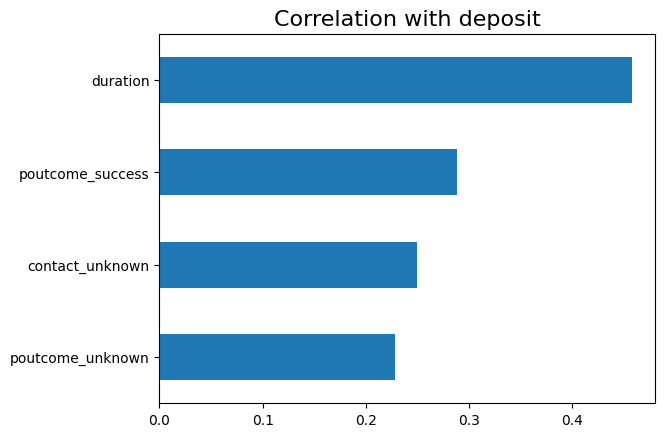

In [46]:
corr = df.corr()

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

Мультиколлинеарность отсутствует

### Определим целевую переменную, разделим выборку на обучающую и тестовую

In [47]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [48]:
X_test.shape

(3335, 45)

In [49]:
round(y_test.mean(), 2)

0.46

### Отберём 15 признаков, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели

In [50]:
from numpy import array 

skb = SelectKBest(k=15)
z = skb.fit_transform(X_train, y_train)
features = skb.get_support()

In [51]:
X_train_new = X_train.iloc[:, skb.get_support()]
X_train_new

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
7287,557.0,1,513,1,-1,0,0,1,0,0,0,0,0,0,1
4766,69.0,0,296,1,205,2,0,1,0,0,0,0,0,0,0
5712,0.0,1,399,2,358,5,0,0,0,0,1,0,0,0,0
2530,444.0,0,137,1,102,5,0,1,0,0,0,0,0,1,0
9294,1444.0,0,100,1,117,8,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,222.0,0,111,1,204,2,4,1,0,0,0,0,0,0,0
1056,1777.0,1,796,5,154,1,2,1,0,0,0,0,0,0,0
2931,3324.0,0,122,1,92,3,3,1,0,0,0,0,0,1,0
7735,209.0,0,605,2,-1,0,4,1,0,0,0,0,0,0,1


In [52]:
X_test_new = X_test.iloc[:, skb.get_support()]

### Нормализуем данные

In [53]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_new)                           
X_train_scaled = scaler.transform(X_train_new)    
X_test_scaled = scaler.transform(X_test_new)      

print(X_test_scaled[:, 0].mean())  

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Реализуем логистическую регрессию

In [54]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [55]:
y_pred = log_reg.predict(X_test_scaled)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred).round(2))

0.81


### Реализуем также решающие деревья

In [56]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)
print(accuracy_score(y_train, y_train_pred).round(2))
print(accuracy_score(y_test, y_pred).round(2))

1.0
0.75


Видим переобучение

In [57]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)
print(accuracy_score(y_train, y_train_pred).round(2))
print(accuracy_score(y_test, y_pred).round(2))

0.82
0.81


Случайным подбором нахождим оптимальную max_depth, при которой нет переобучения и недообучения

### Попробуем реализовать оптимизацию гиперпараметров

In [58]:
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

In [59]:
from sklearn.metrics import f1_score

y_pred = model_cv.predict(X_test_scaled)
print(f1_score(y_test, y_pred).round(2))

0.8


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Обучим случайный лес

In [60]:
from sklearn.metrics import recall_score

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred).round(2))
print(recall_score(y_test, y_pred).round(2))

0.83
0.83


### Попробуем реализовать градиентный бустинг

In [61]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)
print(f1_score(y_test, y_pred).round(2))

0.82


"Случайный лес" даёт немного более качественный результат

### Используем стекинг, объединив применённые ранее модели

In [62]:
from sklearn.metrics import precision_score

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_pred = stack.predict(X_test_scaled)
print(precision_score(y_test, y_pred).round(2))

0.81


### Выявим 3 признака, дающие наибольший вклад в результат маркетинговой кампании

In [63]:
estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)

print(X_train_new.columns[selector.support_])
selector.ranking_

Index(['duration', 'contact_unknown', 'poutcome_success'], dtype='object')


array([ 6,  3,  1,  9,  2, 12,  4, 13,  1,  5, 11,  7,  8,  1, 10])

### Попробуем применить Optuna для оптимизации гиперпараметров

In [64]:
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score_f1 = metrics.f1_score(y_test, model.predict(X_test_scaled))
  score_accuracy = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

  return score_f1

In [65]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2023-03-25 13:32:39,712] A new study created in memory with name: RandomForestClassifier
[I 2023-03-25 13:32:40,529] Trial 0 finished with value: 0.8167406467977172 and parameters: {'n_estimators': 104, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8167406467977172.
[I 2023-03-25 13:32:41,817] Trial 1 finished with value: 0.8178954001260239 and parameters: {'n_estimators': 147, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8178954001260239.
[I 2023-03-25 13:32:43,161] Trial 2 finished with value: 0.8206094879044926 and parameters: {'n_estimators': 164, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8206094879044926.
[I 2023-03-25 13:32:44,414] Trial 3 finished with value: 0.8195892575039494 and parameters: {'n_estimators': 161, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8206094879044926.
[I 2023-03-25 13:32:45,666] Trial 4 finished with value: 0.8160152526215443 and parameters: {'n_

In [66]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 178, 'max_depth': 29, 'min_samples_leaf': 3}


In [67]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

f1_score на тестовом наборе: 0.82
accuracy_score на тестовом наборе: 0.83
